In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import datetime

In [2]:
nielsen15 = pd.read_csv('../../Nielsen/aggregated_nielsen_2015.csv')
nielsen16 = pd.read_csv('../..//Nielsen/aggregated_nielsen_2016.csv')
nielsen15['year'] = 2015
nielsen16['year'] = 2016

nielsen = pd.concat((nielsen15, nielsen16))
nielsen = nielsen[~nielsen.is_walmart]

density_path = r"C:\Users\inesn\Documents\Mines\2A\TR\econometrics\data_collection\plein_de_data\Average_Household_Size_and_Population_Density_-_County.csv"
density = pd.read_csv(density_path)
density = density[["GEOID", "B01001_calc_PopDensity"]]
nielsen = pd.merge(nielsen, density,  how='inner', left_on='guessed_store_county_fips', right_on='GEOID')
nielsen = nielsen.rename(columns={"B01001_calc_PopDensity": "Population density (people/km^2)"})

## Entriy/exit dates
fandom = pd.read_csv('../data_collection/plein_de_data/fandom_traitées.csv', parse_dates=['Opening_date', 'Closing_date'])[['State', 'County_name', 'County_fips', 'Opening_date', 'Closing_date']]

# We drop the state in which we do not trust our data (some mistakes stillremain)
fandom = fandom[~np.isin(fandom.State, ('CA', 'GA', 'KS', 'LA', 'TX'))]
nielsen = nielsen[~np.isin(nielsen.store_state, ('CA', 'GA', 'KS', 'LA', 'TX'))]

# We concentrate our study on the movements (entries & exits) during the fiscal years 2015 and 2016
#movements = fandom[((fandom.Opening_date >= '2015-01-31') & (fandom.Opening_date <= '2017-01-31')) | ((fandom.Closing_date >= '2015-01-31') & (fandom.Closing_date <= '2017-01-31'))]
# Correction des effets de bord M12
movements = fandom[((fandom.Opening_date >= '2014-01-31') & (fandom.Opening_date <= '2018-01-31')) | ((fandom.Closing_date >= '2014-01-31') & (fandom.Closing_date <= '2018-01-31'))]

In [6]:
# global control group
control1 = nielsen[~np.isin(nielsen.guessed_store_county_fips, movements)].copy()

In [7]:
print(f"Size of the control group: {len(control1.guessed_store_county_fips.unique())}.")

Size of the control group: 1802.


________________________________________________________________________________________________________________________________

In [8]:
nb_months = control1.groupby(['guessed_store_county_fips', 'product_group_descr']).count()

In [37]:
nb_months.shape[0]

156470

In [9]:
control1['tupple']=list(zip(control1.guessed_store_county_fips, control1.product_group_descr))
control1['tupple'].head()

0    (1001, BREAD AND BAKED GOODS)
1           (1001, BREAKFAST FOOD)
2                    (1001, CANDY)
3     (1001, CARBONATED BEVERAGES)
4                   (1001, CEREAL)
Name: tupple, dtype: object

In [10]:
mask = control1[['tupple']].isin(nb_months[nb_months.is_walmart==24].index).all(axis=1)

In [49]:
mask.describe()

count     2039457
unique          2
top         False
freq      1174137
dtype: object

In [60]:
control = control1[mask]
print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")

Size of the control group: 1229.


In [61]:
#nb_obs = control.groupby('guessed_store_county_fips').min()
#nb_obs.shape[0]
#control = control[np.isin(control.guessed_store_county_fips, nb_obs[nb_obs.nb_of_obs > 3].index)]
#print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")

In [62]:
# global treatment group
count = movements.groupby('County_fips').count()
count = count[count.State == 1] # No more than one movement in the treatement group
treatment_movements = movements[(np.isin(movements.County_fips, count.index))]
treatment_movements = treatment_movements[(treatment_movements.Opening_date>='2015-01-31' ) & (treatment_movements.Opening_date<='2017-01-31') & ((treatment_movements.Closing_date>'2017-01-31') | (treatment_movements.Closing_date.apply(str) == 'NaT'))]
treatment = nielsen[np.isin(nielsen.guessed_store_county_fips, treatment_movements.County_fips )].copy()
treatment = treatment.merge(treatment_movements, left_on='guessed_store_county_fips', right_on='County_fips')

In [3]:
categories = ["FRESH PRODUCE",
    "BREAD AND BAKED GOODS",
    "MILK",
    "SNACKS",
    "PACKAGED MEATS-DELI",
    "CHEESE",
    "UNPREP MEAT/POULTRY/SEAFOOD-FRZN",
    "CARBONATED BEVERAGES",
    "CONDIMENTS, GRAVIES, AND SAUCES",
    "CANDY",
    "JUICE, DRINKS - CANNED, BOTTLED",
    "EGGS",
    "CEREAL",
    "PASTA",
    "PAPER PRODUCTS",
    "SEAFOOD - CANNED",
    "BEER",
    "BREAKFAST FOODS - FROZEN",
    "COOKIES",
    "COT CHEESE, SOUR CREAM, TOPPINGS",
    "COUGH AND COLD REMEDIES",
    "DEODORANT",
    "DESSERTS/FRUITS/TOPPINGS-FROZEN",
    "DISPOSABLE DIAPERS",
    "DRESSINGS/SALADS/PREP FOODS-DELI",
    "GRT CARDS/PARTY NEEDS/NOVELTIES",
    "ICE CREAM, NOVELTIES",
    "JAMS, JELLIES, SPREADS",
    "PIZZA/SNACKS/HORS DOEUVRES-FRZN",
    "PREPARED FOOD-DRY MIXES",
    "PREPARED FOOD-READY-TO-SERVE",
    "SPICES, SEASONINGS, EXTRACTS",
    "VEGETABLES - CANNED",
    "VEGETABLES-FROZEN",
    "WRAPPING MATERIALS AND BAGS",]


In [63]:
print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")
print(f"Size of the control group: {control.guessed_store_county_fips.count()}.")

Size of the control group: 1229.
Size of the control group: 865320.


0.309754319083627 27819.8048012476


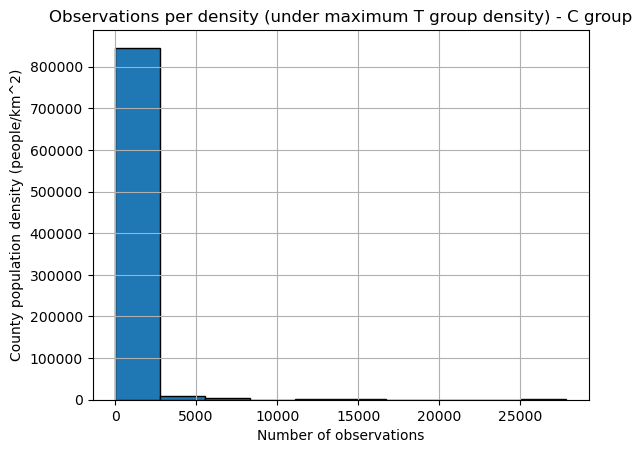

In [64]:
# density distribution of the control group - per observation
print(control["Population density (people/km^2)"].min(),control["Population density (people/km^2)"].max())
plt.hist(control["Population density (people/km^2)"], edgecolor='black')
plt.xlabel('Number of observations')
plt.ylabel('County population density (people/km^2)')
plt.title('Observations per density (under maximum T group density) - C group')
#plt.ylim(0, 3000)
plt.grid(True)
plt.show()

0.309754319083627 27819.8048012476


C:\Users\inesn\AppData\Local\Temp\ipykernel_14708\3375018503.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  control_d = control.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean()


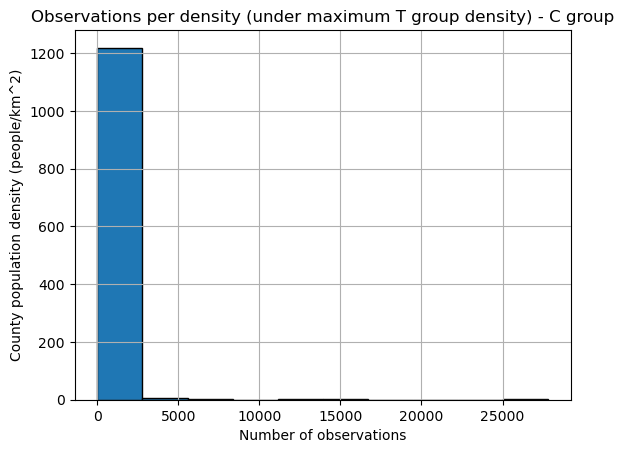

In [65]:
# density distribution of the control group - per county
control_d = control.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean()
print(control_d["Population density (people/km^2)"].min(),control_d["Population density (people/km^2)"].max())
plt.hist(control_d["Population density (people/km^2)"], edgecolor='black')
plt.xlabel('Number of observations')
plt.ylabel('County population density (people/km^2)')
plt.title('Observations per density (under maximum T group density) - C group')
#plt.ylim(0, 3000)
plt.grid(True)
plt.show()

In [66]:
print(f"Size of the treatment group: {len(treatment.guessed_store_county_fips.unique())}.")
print(f"Size of the treatment group: {treatment.guessed_store_county_fips.count()}.")

Size of the treatment group: 65.
Size of the treatment group: 119989.


3.69147125917798 4322.95256868476


C:\Users\inesn\AppData\Local\Temp\ipykernel_14708\1722587604.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  treatment_d = treatment.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean()


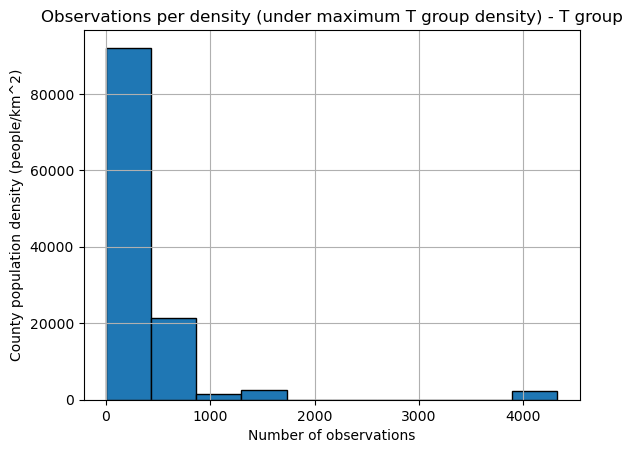

In [69]:
# density distribution of the treatment group - per observation
treatment_d = treatment.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean()
d_t_min = treatment["Population density (people/km^2)"].min()
d_t_max = treatment["Population density (people/km^2)"].max()
print(d_t_min, d_t_max)
plt.hist(treatment["Population density (people/km^2)"], edgecolor='black')
plt.xlabel('Number of observations')
plt.ylabel('County population density (people/km^2)')
plt.title('Observations per density (under maximum T group density) - T group')
#plt.ylim(0, 3000)
plt.grid(True)
plt.show()
#savefig("../../r

3.69147125917798 4322.95256868476


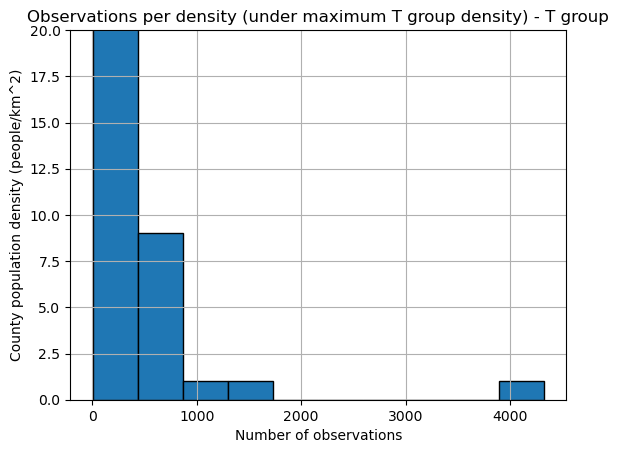

In [76]:
# density distribution of the control group - per county
print(treatment_d["Population density (people/km^2)"].min(),treatment_d["Population density (people/km^2)"].max())
plt.hist(treatment_d["Population density (people/km^2)"], edgecolor='black')
plt.xlabel('Number of observations')
plt.ylabel('County population density (people/km^2)')
plt.title('Observations per density (under maximum T group density) - T group')
plt.ylim(0, 20)
plt.grid(True)
plt.show()
#savefig("../../results_summary/density_control_hist_0.png")

3.69147125917798 4322.95256868476


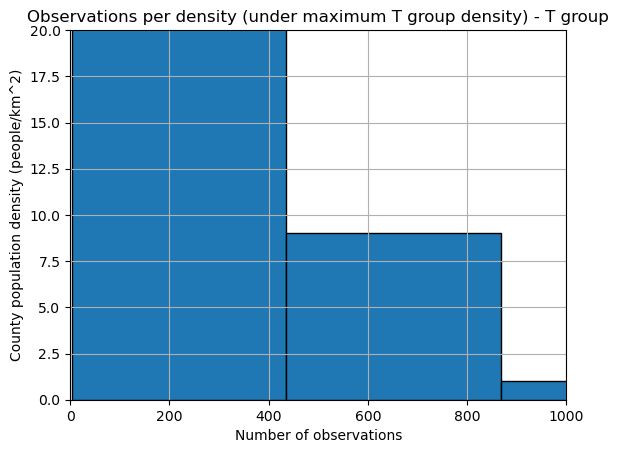

In [77]:
# density distribution of the control group - per county
print(treatment_d["Population density (people/km^2)"].min(),treatment_d["Population density (people/km^2)"].max())
plt.hist(treatment_d["Population density (people/km^2)"], edgecolor='black')
plt.xlabel('Number of observations')
plt.ylabel('County population density (people/km^2)')
plt.title('Observations per density (under maximum T group density) - T group')
plt.ylim(0, 20)
plt.xlim(0, 1000)
plt.grid(True)
plt.show()
#savefig("../../results_summary/density_control_hist_0.png")

On restreint le control group à la plage de valeurs de densités sur laquelle le treatment group est défini, à savoir : [3.69147125917798 ; 4322.95256868476].

Nous pouvons même restreindre à [3.69147125917798 ; 900].

In [78]:
d_t_max_2 = 900

In [84]:
control_d = control_d[(control_d["Population density (people/km^2)"]<=d_t_max_2)]
control = control[(control["Population density (people/km^2)"]<=d_t_max_2)]
treatment = treatment[(treatment["Population density (people/km^2)"]<=d_t_max_2)]
treatment_d = treatment_d[(treatment_d["Population density (people/km^2)"]<=d_t_max_2)]
print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")
print(f"Size of the control group: {control.guessed_store_county_fips.count()}.")

3.71268201702155 885.001303194233


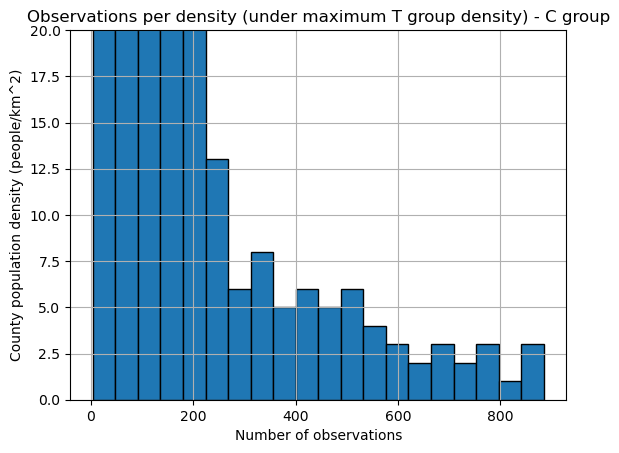

In [91]:
# density distribution of the control group - per observation
print(control_d["Population density (people/km^2)"].min(),control_d["Population density (people/km^2)"].max())
plt.hist(control_d["Population density (people/km^2)"], edgecolor='black', bins = 20)
plt.xlabel('Number of observations')
plt.ylabel('County population density (people/km^2)')
plt.title('Observations per density (under maximum T group density) - C group')
plt.ylim(0, 20)
plt.grid(True)
plt.show()

3.69147125917798 778.069834259078


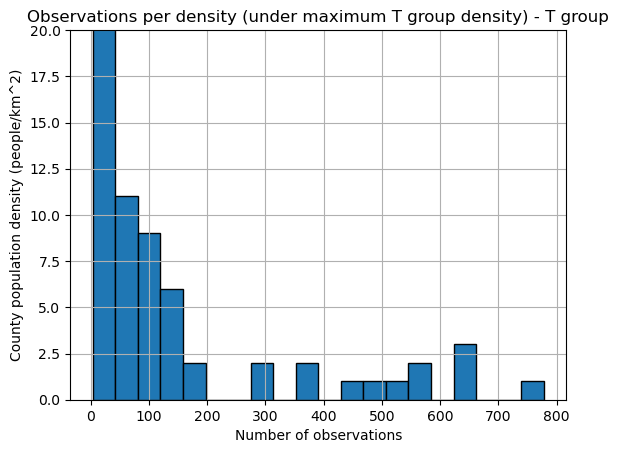

In [90]:
# density distribution of the treatment group - per county
print(treatment_d["Population density (people/km^2)"].min(),treatment_d["Population density (people/km^2)"].max())
plt.hist(treatment_d["Population density (people/km^2)"], edgecolor='black', bins = 20)
plt.xlabel('Number of observations')
plt.ylabel('County population density (people/km^2)')
plt.title('Observations per density (under maximum T group density) - T group')
plt.ylim(0, 20)
#plt.xlim(0, 1000)
plt.grid(True)
plt.show()
#savefig("../../results_summary/density_control_hist_0.png")

In [93]:
treatment_d["Population density (people/km^2)"].describe()

count     62.000000
mean     158.982159
std      197.993982
min        3.691471
25%       32.018520
50%       74.363078
75%      155.915148
max      778.069834
Name: Population density (people/km^2), dtype: float64

### Code

In [ ]:
#We gather information on treatment group counties density
treatment_d = treatment.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean()
#We know  very few treatment group counties are above a 900 people/sqkm density so we drop them
treatment_d = treatment_d[treatment_d["Population density (people/km^2)"]<=900]

#We get the densities values that divide the treatment group in 3 same size county groups
d_1_max = np.percentile(treatment_d["Population density (people/km^2)"], 33)
d_2_max = np.percentile(treatment_d["Population density (people/km^2)"], 66)
d_3_max = 900

#For each county, we register the info on which of the three density groups they are part of
df['low_d']=(df["Population density (people/km^2)"]<=d_1_max)
df['m_d']=(df["Population density (people/km^2)"]>d_1_min)&(df["Population density (people/km^2)"]<=d_2_max)
df['high_d']=(df["Population density (people/km^2)"]>d_2_min)&(df["Population density (people/km^2)"]<=d_3_max)

reg1 = smf.ols(
    formula='np.log(upc_price) ~ treat + interaction + C(time_effects) * C(store_state) + low_d + m_d + high_d',
    data=df)

### Regression

In [21]:
categories = [
    "BUTTER AND MARGARINE",
    "CANDY",
    "CONDIMENTS, GRAVIES, AND SAUCES",
    "COOKIES",
    "COT CHEESE, SOUR CREAM, TOPPINGS",
    "CRACKERS",
    "DRESSINGS/SALADS/PREP FOODS-DELI",
    "MILK",
    "PAPER PRODUCTS",
    "PET FOOD",
    "PREPARED FOOD-DRY MIXES",
    "PREPARED FOOD-READY-TO-SERVE", 
    "PREPARED FOODS-FROZEN",
    "SNACKS",
    "SOFT DRINKS-NON CARBONATED",
    "SPICES, SEASONINGS, EXTRACTS",
    "UNPREP MEAT/POULTRY/SEAFOOD-FRZN",
    "VEGETABLES - CANNED", 
    "VEGETABLES-FROZEN",
    "WRAPPING MATERIALS AND BAGS",
]

In [5]:
# We choose to focus on milk prices
for category in ["CANDY"] :
    print(category)
    product_group = nielsen[nielsen.product_group_descr == category]
    #product_group = pool
    #product_group = nielsen

    # The control group is composed by all states where nothing (no entry nor exit) happened.
    control = product_group[~np.isin(product_group.guessed_store_county_fips, movements)].copy()
    print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")

    # We keep in the control group the only counties where we have data for the entire time period (24 months)
    nb_months = control.groupby('guessed_store_county_fips').count()
    control = control[np.isin(control.guessed_store_county_fips, nb_months[nb_months.is_walmart==24].index)]
    print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")

    nb_obs = control.groupby('guessed_store_county_fips').min()
    control = control[np.isin(control.guessed_store_county_fips, nb_obs[nb_obs.nb_of_obs > 3].index)]
    print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")

    # The treatment group is composed by the states where one entry took place in 2016 and where this entry is the only movement
    count = movements.groupby('County_fips').count()
    count = count[count.State == 1] # No more than one movement in the treatement group
    treatment_movements = movements[(np.isin(movements.County_fips, count.index))]
    treatment_movements = treatment_movements[(treatment_movements.Opening_date>='2015-01-31' ) & (treatment_movements.Opening_date<='2017-01-31') & ((treatment_movements.Closing_date>'2017-01-31') | (treatment_movements.Closing_date.apply(str) == 'NaT'))]

    treatment = product_group[np.isin(product_group.guessed_store_county_fips, treatment_movements.County_fips )].copy()
    treatment = treatment.merge(treatment_movements, left_on='guessed_store_county_fips', right_on='County_fips')
    print(f"Size of the treatment group: {len(treatment.guessed_store_county_fips.unique())}.")



    # We create our dummies for the regression
    control['treat'] = False
    control['interaction'] = False
    control['purchase_0'] = control.purchase_month + 12 * (control.purchase_year - 2015)
    control['effects'] = list(zip(control.store_state, control.purchase_0))
    
    treatment['treat'] = True
    treatment['purchase_0'] = treatment.purchase_month + 12 * (treatment.purchase_year - 2015)
    treatment['opening_0'] = treatment.Opening_date.dt.month  + 12 * (treatment.Opening_date.dt.year - 2015)
    treatment['interaction'] = treatment.purchase_0 >= treatment.opening_0
    treatment['effects'] = list(zip(treatment.store_state, treatment.purchase_0))
    treatment = treatment[abs(treatment.purchase_0-treatment.opening_0) >= 6]


    # Final dataset for the regression :

    df = pd.concat((control, treatment))[['upc_price', 'treat', 'interaction', 'effects', "Population density (people/km^2)"]]
    df = df[df.upc_price != 0]
    
    #We create our density dummies for the regression
    
    #We gather information on treatment group counties density
    treatment_d = treatment.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean()
    #We know  very few treatment group counties are above a 900 people/sqkm density so we drop them
    treatment_d = treatment_d[treatment_d["Population density (people/km^2)"]<=900]
    #We get the densities values that divide the treatment group in 3 same size county groups
    if treatment_d.shape[0] > 0 :
        d_1_max = np.percentile(treatment_d["Population density (people/km^2)"], 33)
        d_2_max = np.percentile(treatment_d["Population density (people/km^2)"], 66)
        d_3_max = 900
        #For each county, we register the info on which of the three density groups they are part of
        df['low_d']=(df["Population density (people/km^2)"]<=d_1_max)
        df['m_d']=(df["Population density (people/km^2)"]>d_1_max)&(df["Population density (people/km^2)"]<=d_2_max)
        df['high_d']=(df["Population density (people/km^2)"]>d_2_max)&(df["Population density (people/km^2)"]<=d_3_max)
        
        for d_cat in ['low_d','m_d','high_d'] :
            df2 = df[df[d_cat]]
            print(df2.shape[0])
            if df2.shape[0]>0 :
                reg1 = smf.ols(formula='np.log(upc_price) ~ treat + interaction + C(effects)', data=df2)
                results1 = reg1.fit()
                print("=========================================================")
                print(d_cat)
                print(f"Coef : {np.exp(results1.params[2])-1}")
                print(results1.bse[2])
                if abs(results1.params[2] / results1.bse[2]) >= 2.:
                    print(f"Coef : {np.exp(results1.params[2])-1}")
                print(f"Coef/err : {abs(results1.params[2] / results1.bse[2])}")
                if abs(results1.params[2] / results1.bse[2]) >= 2.:
                    print(f"CI_up : {np.exp(results1.conf_int(alpha=0.05)[0][2])-1}")
                    print(f"CI_down : {np.exp(results1.conf_int(alpha=0.05)[1][2])-1}")
                print(f"p_value : {results1.pvalues[2]}")
                print(f"nobs : {results1.nobs}")
                print(f"R squared : {results1.rsquared}")

CANDY
Size of the control group: 1751.
Size of the control group: 701.
Size of the control group: 460.
Size of the treatment group: 65.
3350


C:\Users\inesn\AppData\Local\Temp\ipykernel_3832\3210114737.py:55: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  treatment_d = treatment.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean()


low_d
Coef : 0.019498128163102146
0.05152456475345919
Coef/err : 0.3747819140026873
p_value : 0.7078545569101041
nobs : 3350.0
R squared : 0.4198481140966587
4278
m_d
Coef : 0.06912941919501803
0.03286374507566734
Coef : 0.06912941919501803
Coef/err : 2.03399491522753
CI_up : 0.002412982960408927
CI_down : 0.14028622376035393
p_value : 0.04202931313773765
nobs : 4278.0
R squared : 0.3400059039710335
3744
high_d
Coef : 0.057993988928382256
0.021904975343388075
Coef : 0.057993988928382256
Coef/err : 2.573600334812165
CI_up : 0.013514924583306831
CI_down : 0.10442505922524625
p_value : 0.01011210383510119
nobs : 3744.0
R squared : 0.452090528584436


### On pooled dataset

In [4]:
#For each county and each month we take the mean of the prices of all categories
pool = nielsen.groupby(['store_state','guessed_store_county','guessed_store_county_fips','purchase_month','purchase_year']).mean().reset_index()
product_group = pool

# The control group is composed of all states where nothing (no entry nor exit) happened.
control = product_group[~np.isin(product_group.guessed_store_county_fips, movements)].copy()

# We keep in the control group the only counties where we have data for the entire time period (24 months)
nb_months = control.groupby('guessed_store_county_fips').count()
control = control[np.isin(control.guessed_store_county_fips, nb_months[nb_months.is_walmart==24].index)]
print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")

# The treatment group is composed of the states where one entry took place in 2016 and where this entry is the only movement
count = movements.groupby('County_fips').count()
count = count[count.State == 1] # No more than one movement in the treatement group
treatment_movements = movements[(np.isin(movements.County_fips, count.index))]
treatment_movements = treatment_movements[(treatment_movements.Opening_date>='2015-01-31' ) & (treatment_movements.Opening_date<='2017-01-31') & ((treatment_movements.Closing_date>'2017-01-31') | (treatment_movements.Closing_date.apply(str) == 'NaT'))]

treatment = product_group[np.isin(product_group.guessed_store_county_fips, treatment_movements.County_fips )].copy()
treatment = treatment.merge(treatment_movements, left_on='guessed_store_county_fips', right_on='County_fips')
print(f"Size of the treatment group: {len(treatment.guessed_store_county_fips.unique())}.")

# We create our dummies for the regression
control['treat'] = False
control['interaction'] = False
control['purchase_0'] = control.purchase_month + 12 * (control.purchase_year - 2015)
control['effects'] = list(zip(control.store_state, control.purchase_0))

treatment['treat'] = True
treatment['purchase_0'] = treatment.purchase_month + 12 * (treatment.purchase_year - 2015)
treatment['opening_0'] = treatment.Opening_date.dt.month  + 12 * (treatment.Opening_date.dt.year - 2015)
treatment['interaction'] = treatment.purchase_0 >= treatment.opening_0
treatment['effects'] = list(zip(treatment.store_state, treatment.purchase_0))

#we take only months before 5 months before the entry and months after 5 months after the entry
treatment = treatment[abs(treatment.purchase_0-treatment.opening_0) >= 6]

#if the treatment group is not empty
if treatment.shape[0]>0 :
    
    # Final dataset for the regression :
    df = pd.concat((control, treatment))[['upc_price', 'treat', 'interaction', 'effects', "Population density (people/km^2)"]]
    df = df[df.upc_price != 0]
    
    #We create our density dummies for the regression
    
    #We gather information on treatment group counties density
    treatment_d = treatment.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean()
    #We know  very few treatment group counties are above a 900 people/sqkm density so we drop them
    treatment_d = treatment_d[treatment_d["Population density (people/km^2)"]<=900]
    #We get the densities values that divide the treatment group in 3 same size county groups
    if treatment_d.shape[0] > 0 :
        d_1_max = np.percentile(treatment_d["Population density (people/km^2)"], 33)
        d_2_max = np.percentile(treatment_d["Population density (people/km^2)"], 66)
        d_3_max = 900
        #For each county, we register the info on which of the three density groups they are part of
        df['low_d']=(df["Population density (people/km^2)"]<=d_1_max)
        df['m_d']=(df["Population density (people/km^2)"]>d_1_max)&(df["Population density (people/km^2)"]<=d_2_max)
        df['high_d']=(df["Population density (people/km^2)"]>d_2_max)&(df["Population density (people/km^2)"]<=d_3_max)

        for d_cat in ['low_d','m_d','high_d'] :
            df2 = df[df[d_cat]]
            print(df2.shape[0])
            if df2.shape[0]>0 :
                reg1 = smf.ols(formula='np.log(upc_price) ~ treat + interaction + C(effects)', data=df2)
                results1 = reg1.fit()
                print("=========================================================")
                print(d_cat)
                print(f"Coef : {np.exp(results1.params[2])-1}")
                print(results1.bse[2])
                if abs(results1.params[2] / results1.bse[2]) >= 2.:
                    print(f"Coef : {np.exp(results1.params[2])-1}")
                print(f"Coef/err : {abs(results1.params[2] / results1.bse[2])}")
                if abs(results1.params[2] / results1.bse[2]) >= 2.:
                    print(f"CI_up : {np.exp(results1.conf_int(alpha=0.05)[0][2])-1}")
                    print(f"CI_down : {np.exp(results1.conf_int(alpha=0.05)[1][2])-1}")
                print(f"p_value : {results1.pvalues[2]}")
                print(f"nobs : {results1.nobs}")
                print(f"R squared : {results1.rsquared}")

C:\Users\inesn\AppData\Local\Temp\ipykernel_3832\596230543.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pool = nielsen.groupby(['store_state','guessed_store_county','guessed_store_county_fips','purchase_month','purchase_year']).mean().reset_index()


Size of the control group: 1390.
Size of the treatment group: 65.
21990


C:\Users\inesn\AppData\Local\Temp\ipykernel_3832\596230543.py:48: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  treatment_d = treatment.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean()


low_d
Coef : 0.01123492763514422
0.03049122221084752
Coef/err : 0.3664098642916393
p_value : 0.714062942361637
nobs : 21990.0
R squared : 0.15792356204816316
7336
m_d
Coef : 0.05342936665232667
0.02589238305710585
Coef : 0.05342936665232667
Coef/err : 2.0102786805124473
CI_up : 0.0012941086470807939
CI_down : 0.10827919683351994
p_value : 0.04444312689831095
nobs : 7336.0
R squared : 0.15141483434581593
4248
high_d
Coef : 0.044364723670801354
0.018308503501338256
Coef : 0.044364723670801354
Coef/err : 2.3709627945893432
CI_up : 0.007540694445966167
CI_down : 0.0825346133018976
p_value : 0.01779547230458737
nobs : 4248.0
R squared : 0.2848108535360415


In [18]:
#For each county and each month we take the mean of the prices of all categories
pool = nielsen.groupby(['store_state','guessed_store_county','guessed_store_county_fips','purchase_month','purchase_year']).mean().reset_index()
product_group = pool

# The control group is composed of all states where nothing (no entry nor exit) happened.
control = product_group[~np.isin(product_group.guessed_store_county_fips, movements)].copy()

# We keep in the control group the only counties where we have data for the entire time period (24 months)
nb_months = control.groupby('guessed_store_county_fips').count()
control = control[np.isin(control.guessed_store_county_fips, nb_months[nb_months.is_walmart==24].index)]
print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")

# The treatment group is composed of the states where one entry took place in 2016 and where this entry is the only movement
count = movements.groupby('County_fips').count()
count = count[count.State == 1] # No more than one movement in the treatement group
treatment_movements = movements[(np.isin(movements.County_fips, count.index))]
treatment_movements = treatment_movements[(treatment_movements.Opening_date>='2015-01-31' ) & (treatment_movements.Opening_date<='2017-01-31') & ((treatment_movements.Closing_date>'2017-01-31') | (treatment_movements.Closing_date.apply(str) == 'NaT'))]

treatment = product_group[np.isin(product_group.guessed_store_county_fips, treatment_movements.County_fips )].copy()
treatment = treatment.merge(treatment_movements, left_on='guessed_store_county_fips', right_on='County_fips')
print(f"Size of the treatment group: {len(treatment.guessed_store_county_fips.unique())}.")

# We create our dummies for the regression
control['treat'] = False
control['interaction'] = False
control['purchase_0'] = control.purchase_month + 12 * (control.purchase_year - 2015)
control['effects'] = list(zip(control.store_state, control.purchase_0))

treatment['treat'] = True
treatment['purchase_0'] = treatment.purchase_month + 12 * (treatment.purchase_year - 2015)
treatment['opening_0'] = treatment.Opening_date.dt.month  + 12 * (treatment.Opening_date.dt.year - 2015)
treatment['interaction'] = treatment.purchase_0 >= treatment.opening_0
treatment['effects'] = list(zip(treatment.store_state, treatment.purchase_0))

#we take only months before 5 months before the entry and months after 5 months after the entry
treatment = treatment[abs(treatment.purchase_0-treatment.opening_0) >= 6]

#if the treatment group is not empty
if treatment.shape[0]>0 :
    
    # Final dataset for the regression :
    df = pd.concat((control, treatment))[['upc_price', 'treat', 'interaction', 'effects', "Population density (people/km^2)"]]
    df = df[df.upc_price != 0]
    
    #We create our density dummies for the regression
    
    #We gather information on treatment group counties density
    treatment_d = treatment.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean()
    #We know  very few treatment group counties are above a 900 people/sqkm density so we drop them
    treatment_d = treatment_d[treatment_d["Population density (people/km^2)"]<=900]
    #We get the densities values that divide the treatment group in 3 same size county groups
    if treatment_d.shape[0] > 0 :
        d_1_max = np.percentile(treatment_d["Population density (people/km^2)"], 33)
        d_2_max = np.percentile(treatment_d["Population density (people/km^2)"], 66)
        d_3_max = 900
        #For each county, we register the info on which of the three density groups they are part of
        df['low_d']=(df["Population density (people/km^2)"]<=d_1_max)
        df['m_d']=(df["Population density (people/km^2)"]>d_1_max)&(df["Population density (people/km^2)"]<=d_2_max)
        df['high_d']=(df["Population density (people/km^2)"]>d_2_max)&(df["Population density (people/km^2)"]<=d_3_max)

        reg1 = smf.ols(formula='np.log(upc_price) ~ treat + interaction + low_d + m_d + high_d + C(effects)', data=df)
        results1 = reg1.fit()
        print("=========================================================")
        if abs(results1.params[2] / results1.bse[2]) >= 2.:
            print(f"Coef : {np.exp(results1.params[2])-1}")
        print(f"Coef/err : {abs(results1.params[2] / results1.bse[2])}")
        if abs(results1.params[2] / results1.bse[2]) >= 2.:
            print(np.exp(results1.params[3:6])-1)
            print(np.abs(results1.params[3:6] / results1.bse[3:6]))
            print(f"p_value : {results1.pvalues[3:6]}")
            print(f"CI_up : {np.exp(results1.conf_int(alpha=0.05)[0][2])-1}")
            print(f"CI_down : {np.exp(results1.conf_int(alpha=0.05)[1][2])-1}")
        print(f"p_value : {results1.pvalues[2]}")
        print(f"nobs : {results1.nobs}")
        print(f"R squared : {results1.rsquared}")

C:\Users\inesn\AppData\Local\Temp\ipykernel_35288\3101753620.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pool = nielsen.groupby(['store_state','guessed_store_county','guessed_store_county_fips','purchase_month','purchase_year']).mean().reset_index()


Size of the control group: 1390.
Size of the treatment group: 65.


C:\Users\inesn\AppData\Local\Temp\ipykernel_35288\3101753620.py:48: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  treatment_d = treatment.groupby(["store_state","guessed_store_county_fips", "guessed_store_county"]).mean()


Coef : 0.037945995721688996
Coef/err : 2.408551503670152
low_d[T.True]    -0.243097
m_d[T.True]      -0.113195
high_d[T.True]   -0.004207
dtype: float64
low_d[T.True]     29.971581
m_d[T.True]       12.786609
high_d[T.True]     0.441788
dtype: float64
p_value : low_d[T.True]     9.107056e-195
m_d[T.True]        2.386324e-37
high_d[T.True]     6.586452e-01
dtype: float64
CI_up : 0.006959570721073671
CI_down : 0.06988594314985419
p_value : 0.0160213767811306
nobs : 34263.0
R squared : 0.2768615519928078
